In [1]:
import gensim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns

from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")


## Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')
pd.set_option("display.max_colwidth", -1)
df = pd.read_csv('/content/drive/MyDrive/MFE230T1-2021/class_notebooks/5-Deep_Learning-Keras/all-data.csv',delimiter=',',encoding='latin-1', header=None)
df = df.rename(columns={0:'Sentiment',1:'Message'})
df.head(10)

Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


,Sentiment,Message
0,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
1,neutral,"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said ."
2,negative,"The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported ."
3,positive,With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .
4,positive,"According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net sales ."
5,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is aggressively pursuing its growth strategy by increasingly focusing on technologically more demanding HDI printed circuit boards PCBs .
6,positive,"For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m ."
7,positive,"In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn ."
8,positive,Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .
9,positive,"Operating profit totalled EUR 21.1 mn , up from EUR 18.6 mn in 2007 , representing 9.7 % of net sales ."


In [3]:
df.shape

(4846, 2)

## Visualizing the Data and Preprocessing

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


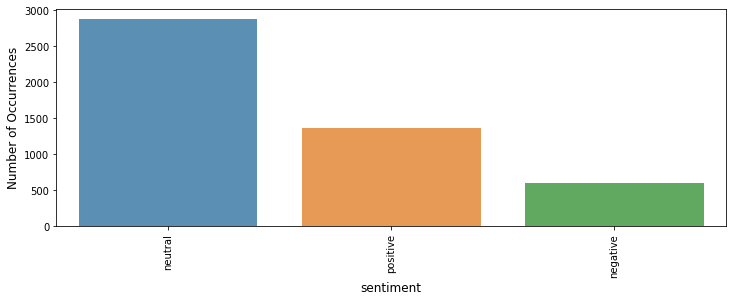

In [4]:
cnt_pro = df['Sentiment'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('sentiment', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [5]:
#Convert string to numeric
#FIX this
sentiment  = {'positive': 0,'neutral': 1,'negative':2} 
pd.set_option("display.max_colwidth", -1)
df.Sentiment = [sentiment[item] for item in df.Sentiment] 
df[['sentiment_0',  'sentiment_1'  ,'sentiment_2']] = pd.get_dummies(df.Sentiment, prefix='sentiment')
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,Sentiment,Message,sentiment_0,sentiment_1,sentiment_2
0,1,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .",0,1,0
1,1,"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .",0,1,0
2,2,"The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .",0,0,1
3,0,With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .,1,0,0
4,0,"According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net sales .",1,0,0


In [6]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['Message'] = df['Message'].apply(cleanText)

In [7]:
train, test = train_test_split(df, test_size=0.000001 , random_state=42)
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r['sentiment_0'], r['sentiment_1'], r['sentiment_2']]), axis=1)

print(train_tagged)
# The maximum number of words to be used. (most frequent)
max_features = 50000

# Max number of words in each news.
MAX_SEQUENCE_LENGTH = 128

#tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer = Tokenizer(num_words=max_features, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train['Message'].values)
X = tokenizer.texts_to_sequences(train['Message'].values)
X = pad_sequences(X)
print('Found %s unique tokens.' % len(X))
print(X)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
1684    ([unc, charlotte, would, also, deploy, ssh, tectia, connector, to, enable, secure, application, connectivity, .], [0, 1, 0])                                                                                                                                                                      
1044    ([in, 2009, ,, lee, &, man, had, a, combined, annual, production, capacity, of, close, to, 4.5, million, tonnes, of, paper, and, 300,000, tonnes, of, pulp, .], [0, 1, 0])                                                                                                                        
4145    ([``, that, 's, a, very, high, figure, on, the, european, scale, ,, '', noop, said, ,, recalling, however, that, this, also, includes, beer, bought, by, finnish, tourists, .], [0, 1, 0])                                                                                                      

In [8]:
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (4846, 128)


In [9]:
## Doc2Vec word Embedding
d2v_model = Doc2Vec(dm=1, dm_mean=1, size=25, window=5, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])

/usr/local/lib/python3.7/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 4845/4845 [00:00<00:00, 1009608.65it/s]


In [10]:
%%time
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|██████████| 4845/4845 [00:00<00:00, 2551337.46it/s]


CPU times: user 13.7 s, sys: 114 ms, total: 13.8 s
Wall time: 14.1 s


In [11]:
top = 10
embedding_vector_length = 20
# Save the vectors in a new matrix
embedding_matrix = np.zeros((len(d2v_model.wv.vocab)+ 1, embedding_vector_length))

for i, vec in enumerate(d2v_model.docvecs.vectors_docs):
    while i in vec <= 1000:
        embedding_matrix[i]=vec

## Word Similarity
d2v_model.wv.most_similar(positive=['profit'], topn=top)

[('loss', 0.9091370105743408),
 ('profits', 0.8054261207580566),
 ('income', 0.7445743083953857),
 ('sacanfil', 0.7356542348861694),
 ('190mn', 0.6798214316368103),
 ('chopra', 0.6753429770469666),
 ('deramus', 0.6686542630195618),
 ('atul', 0.6624585390090942),
 ('26.9', 0.6575296521186829),
 ('eur928', 0.6553850769996643)]

## LSTM Model

In [12]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout

# init layer
model = Sequential()


# emmbed word vectors from word2vec
model.add(Embedding(len(d2v_model.wv.vocab)+1, embedding_vector_length, input_length=X.shape[1], weights=[embedding_matrix],trainable=True))
#model.add(Embedding(len(d2v_model.wv.vocab)+1, embedding_vector_length, input_length=X.shape[1]))

# learn the correlations
def split_input(sequence):
     return sequence[:-1], tf.reshape(sequence[1:], (-1,1))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(3, activation="softmax"))

# output model skeleton
model.summary()
model.compile(optimizer="rmsprop",loss="categorical_crossentropy",metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 128, 20)           233680    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               48400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 303       
Total params: 282,383
Trainable params: 282,383
Non-trainable params: 0
_________________________________________________________________


In [13]:
Y = pd.get_dummies(df['Sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4119, 128) (4119, 3)
(727, 128) (727, 3)


In [14]:
batch_size = 32
history=model.fit(X_train, Y_train, validation_split=0.1, epochs=20, batch_size=batch_size, verbose = 2)

Epoch 1/20
116/116 - 15s - loss: 0.8752 - acc: 0.6253 - val_loss: 0.8025 - val_acc: 0.6408
Epoch 2/20
116/116 - 12s - loss: 0.6845 - acc: 0.6989 - val_loss: 0.7872 - val_acc: 0.6553
Epoch 3/20
116/116 - 12s - loss: 0.5580 - acc: 0.7623 - val_loss: 0.8035 - val_acc: 0.6626
Epoch 4/20
116/116 - 12s - loss: 0.4428 - acc: 0.8214 - val_loss: 0.8600 - val_acc: 0.6602
Epoch 5/20
116/116 - 12s - loss: 0.3456 - acc: 0.8748 - val_loss: 0.9044 - val_acc: 0.6796
Epoch 6/20
116/116 - 12s - loss: 0.2652 - acc: 0.9026 - val_loss: 0.9490 - val_acc: 0.6990
Epoch 7/20
116/116 - 12s - loss: 0.2190 - acc: 0.9231 - val_loss: 0.9318 - val_acc: 0.6845
Epoch 8/20
116/116 - 12s - loss: 0.1702 - acc: 0.9434 - val_loss: 1.1978 - val_acc: 0.6796
Epoch 9/20
116/116 - 12s - loss: 0.1398 - acc: 0.9525 - val_loss: 1.1065 - val_acc: 0.7015
Epoch 10/20
116/116 - 12s - loss: 0.1226 - acc: 0.9576 - val_loss: 1.2553 - val_acc: 0.6820
Epoch 11/20
116/116 - 12s - loss: 0.0984 - acc: 0.9671 - val_loss: 1.3047 - val_acc: 0.66

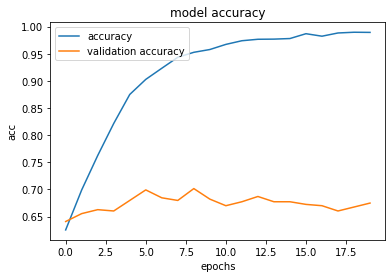

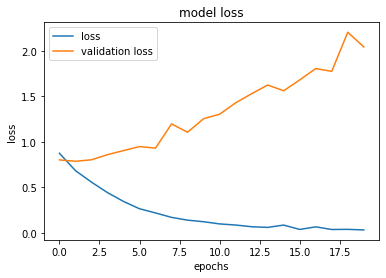

In [15]:
## Visualizing the loss
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['accuracy', 'validation accuracy'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['loss', 'validation loss'], loc='upper left')
plt.show()

In [16]:
# Evaluate the model
_, train_acc = model.evaluate(X_train, Y_train, verbose=2)
_, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

129/129 - 4s - loss: 0.2206 - acc: 0.9607
23/23 - 1s - loss: 1.7136 - acc: 0.7098
Train: 0.961, Test: 0.7098


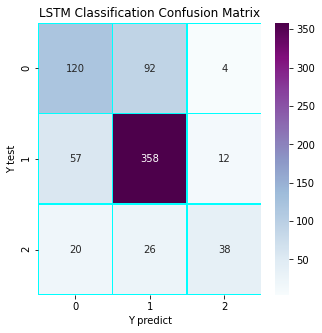

In [17]:
from sklearn.metrics import confusion_matrix

# Labels
rounded_labels=np.argmax(Y_test, axis=1)

# Predict classes for test set
yhat_probs = model.predict(X_test, verbose=0)
yhat_classes = np.argmax(yhat_probs, axis=1)

# Confusion Matrix
lstm_val = confusion_matrix(rounded_labels, yhat_classes)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(lstm_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

## Test the model

In [18]:
message = ['Salesforce on record Q2: Products more relevant than ever']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

[[9.9145108e-01 2.4783923e-04 8.3010523e-03]] 0
